В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [297]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [298]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [299]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [300]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, hidden_layer_sizes = [1,1], normalize = True, learning_rate = 0.01, num_iter = 30000, eps = 10**-2):
        self.layer_sizes = hidden_layer_sizes 
        self.layers_count = len(self.layer_sizes) + 1
        self.parameters = {}
        self.eps = eps
        self.COST_APPEND_T = 1

        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))

    def __sigmoid_derivative(self, Z):
        sig = self.__sigmoid(Z)
        return sig*(1 - sig)
    
    def __initialize_parameters(self):
        n_i = self.layer_sizes
        for i in range(self.layers_count):
            Wi = np.random.randn(n_i[i+1], n_i[i]) * 0.01
            bi = np.zeros((n_i[i+1], 1))
            self.parameters[f"W{i+1}"] = Wi
            self.parameters[f"b{i+1}"] = bi
       
    def __forward_propagation(self, X):
        Aj = X
        cache = [Aj]
        for i in range(self.layers_count):
            Wi, bi = self.parameters[f"W{i+1}"], self.parameters[f"b{i+1}"]
            Zi = np.dot(Wi, Aj) + bi
            Aj = self.__sigmoid(Zi)
            cache.extend([Wi, bi, Zi, Aj])

        return Aj, cache 

    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        grads = {}
        pre = self.layers_count - 1
        for i in reversed(range(self.layers_count)):
            (*cache, Wi, bi, Zi, Ai) = cache
            if i == pre:
                dAi = -np.divide(Y, Ai) + np.divide(1 - Y, 1 - Ai) 
            dZi = dAi*self.__sigmoid_derivative(Zi)
            dWi = np.dot(dZi, cache[-1].T)/m
            dbi = np.sum(dZi, axis=1, keepdims=True)/m
            dAi = np.dot(Wi.T, dZi)

            grads[f"dZ{i+1}"] = dZi
            grads[f"dW{i+1}"] = dWi
            grads[f"db{i+1}"] = dbi

        return grads
    
    def __update_parameters(self, grads):
        for i in range(self.layers_count):
            Wi = self.parameters[f"W{i+1}"]
            bi = self.parameters[f"b{i+1}"]
            dWi = grads[f"dW{i+1}"]
            dbi = grads[f"db{i+1}"]
            self.parameters[f"W{i+1}"] = Wi - self.learning_rate * dWi
            self.parameters[f"b{i+1}"] = bi - self.learning_rate * dbi

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T #Convert vertical to horizontal matrices
        
        if self.normalize: #Normalize
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = [] #Costs log

        self.layer_sizes.insert(0, X.shape[0]) #Input layer
        self.layer_sizes.append(1) #Output layer
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            #OUTPUT
            if print_cost and i % 1000 == 0: #Print cost every 1000 iterations
                print("{}-th iteration: {}".format(i, cost))

            if i % self.COST_APPEND_T == 0: #Append cost every 1000 iterations
                costs.append(cost)
            
            if(i>=self.COST_APPEND_T*2):
                if(abs(costs[-1] - costs[-2]) < self.eps):
                    break

        #Plot costs
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel(f"Iteration, *{self.COST_APPEND_T}")
            plt.show()

    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [301]:
# data_columns = ["exam1", "exam2"]
# target_column = "submitted"
# df = pd.read_csv("sats.csv")
# X, Y = df[data_columns].values, df[target_column]#.reshape((df.shape[0], 1))
# print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [302]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


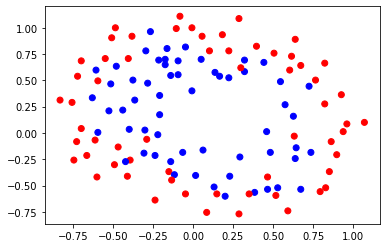

In [303]:
plot_data(X, Y)

In [304]:
cls = NeuralNet(hidden_layer_sizes=[4,3], normalize = True, learning_rate = 0.5, num_iter = 4000, eps=10**-10)

0-th iteration: 0.6931302324172848


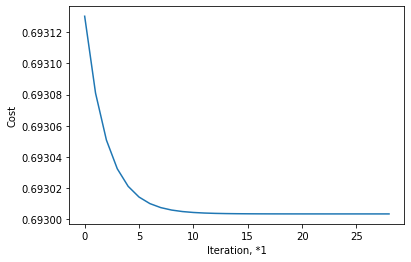

In [305]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [306]:
print(cls.parameters)

{'W1': array([[ 0.00789911, -0.00064038],
       [-0.01638477, -0.01695057],
       [ 0.01405017,  0.00614499],
       [-0.00155119,  0.00570664]]), 'b1': array([[-3.29292385e-08],
       [-3.07326855e-08],
       [-1.32649872e-07],
       [-1.20754573e-07]]), 'W2': array([[ 4.41788263e-03, -1.00284003e-02,  6.28550195e-03,
        -1.90444118e-02],
       [-5.44643530e-03,  1.13048056e-04, -1.22845656e-02,
        -2.12333480e-03],
       [ 1.12288841e-02,  2.02833898e-03,  4.70978142e-05,
        -1.24495141e-02]]), 'b2': array([[1.48415168e-05],
       [5.12167094e-05],
       [7.37037107e-06]]), 'W3': array([[-0.00835808, -0.01632482, -0.00673632]]), 'b3': array([[-0.01822559]])}


In [307]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.49153161, 0.50846839],
       [0.49153166, 0.50846834],
       [0.49153163, 0.50846837],
       [0.49153167, 0.50846833],
       [0.49153161, 0.50846839],
       [0.49153162, 0.50846838],
       [0.49153161, 0.50846839],
       [0.49153161, 0.50846839],
       [0.49153163, 0.50846837],
       [0.49153163, 0.50846837],
       [0.49153162, 0.50846838],
       [0.49153161, 0.50846839],
       [0.49153166, 0.50846834],
       [0.49153167, 0.50846833],
       [0.49153162, 0.50846838],
       [0.4915316 , 0.5084684 ],
       [0.49153164, 0.50846836],
       [0.49153163, 0.50846837],
       [0.49153161, 0.50846839],
       [0.4915316 , 0.5084684 ],
       [0.49153165, 0.50846835],
       [0.49153163, 0.50846837],
       [0.49153163, 0.50846837],
       [0.49153167, 0.50846833],
       [0.49153165, 0.50846835],
       [0.49153166, 0.50846834],
       [0.49153162, 0.50846838],
       [0.49153166, 0.50846834],
       [0.49153161, 0.50846839],
       [0.49153161, 0.50846839],
       [0.

In [308]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [309]:
accuracy_score(Y, Y_hat)

0.5084745762711864

C:\Users\MarKson\AppData\Local\Temp\ipykernel_11644\1714921773.py:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


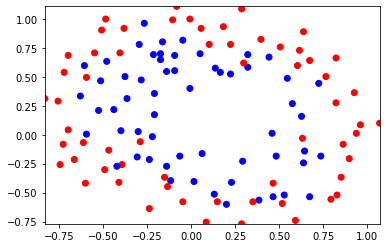

In [310]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [311]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [312]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=10000)

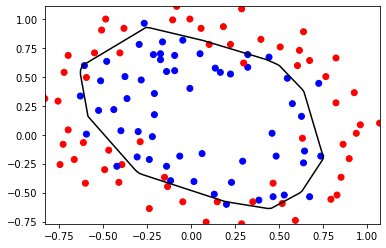

In [313]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [314]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [315]:
clf.n_iter_

1409